## Практическая работа

## Цели практической работы

*  решить реальную задачу;
*  потренироваться в обработке данных;
*  обучить различные модели классификации, подобрать гиперпараметры и выбрать лучшую модель;
*  добиться наилучшего качества в задаче.

## Что входит в практическую работу

*  исследование датасета и обработка данных (работа с пропущенными и ошибочными значениями);
*  обучение различных моделей классификации с параметрами по умолчанию;
*  подбор гиперпараметров моделей;
*  смешивание моделей;
*  оценка качества моделей.

## Что оценивается

*  Выполнены все этапы задания: код запускается, отрабатывает без ошибок; подробно и обоснованно написаны текстовые выводы, где это требуется.

## Формат сдачи
Выполните предложенные задания: впишите свой код (или, если требуется, текст) в ячейки после комментариев. 

*Комментарии — это текст, который начинается с символа #. Например: # ваш код здесь.*

Сохраните изменения, используя опцию Save and Checkpoint из вкладки меню File или кнопку Save and Checkpoint на панели инструментов. Итоговый файл в формате .ipynb (файл Jupyter Notebook) загрузите в личный кабинет и отправьте на проверку.

### 1. Загрузите тренировочные и тестовые датасеты

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [2]:
Xtrain = pd.read_csv("data/TrainData.csv")
Xtest = pd.read_csv("data/TestData.csv")
print(Xtrain.shape, Xtest.shape)

(7500, 15) (2500, 15)


In [3]:
print(Xtrain.columns)
print(Xtrain.shape)
Xtrain.head()

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'target'],
      dtype='object')
(7500, 15)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,50,218.593930,273536,0.104575,4,0.445026,0.274531,0.444334,5.970149,0.300298,0.0,0,49,0.100000,0
1,32,276.771005,173314,0.224684,11,0.445026,0.439103,0.444334,5.970149,0.300298,0.0,0,60,0.244418,0
2,38,218.593930,28887,0.032491,7,0.445026,0.274531,0.444334,25.606721,0.300298,0.0,0,50,0.244418,0
3,19,218.593930,427862,0.179322,10,0.049127,0.044987,0.009499,25.606721,0.300298,0.0,0,35,0.244418,0
4,44,218.593930,109339,0.032491,7,0.098837,0.115721,0.066581,5.970149,0.113590,0.0,0,46,0.185185,0


In [4]:
# посмотрим на количество дубликатов
print('duplicated', sum(Xtrain.duplicated()), 'shape', Xtrain.shape)
# и проконтролируем целевую переменную
print(Xtrain['target'].value_counts())

# посмотрим на количество дубликатов
print('duplicated', sum(Xtest.duplicated()), 'shape', Xtest.shape)
# и проконтролируем целевую переменную
print(Xtest['target'].value_counts())

duplicated 0 shape (7500, 15)
target
0    5708
1    1792
Name: count, dtype: int64
duplicated 0 shape (2500, 15)
target
0    1913
1     587
Name: count, dtype: int64


### 2. Изучите тренировочные и тестовые данные на наличие:
- пропусков,
- ошибочных значений.

Обработайте пропуски и ошибочные значения способом, выбранным по своему усмотрению.

#### Пропуски

In [5]:
# пропуски
missing_values_train = ((Xtrain.isna().sum() / len(Xtrain)) * 100).sort_values(ascending=False)
missing_values_test = ((Xtest.isna().sum() / len(Xtest)) * 100).sort_values(ascending=False)
print('train', missing_values_train)
print('test', missing_values_test)
# создадим переменные содержащие пропуски
missing_train = missing_values_train[missing_values_train.values > 0].index.tolist()
missing_test = missing_values_test[missing_values_test.values > 0].index.tolist()
print(missing_train)
print(missing_test)



train f7        25.000000
f2         1.000000
f11        0.133333
f1         0.000000
f3         0.000000
f4         0.000000
f5         0.000000
f6         0.000000
f8         0.000000
f9         0.000000
f10        0.000000
f12        0.000000
f13        0.000000
f14        0.000000
target     0.000000
dtype: float64
test f1        0.0
f2        0.0
f3        0.0
f4        0.0
f5        0.0
f6        0.0
f7        0.0
f8        0.0
f9        0.0
f10       0.0
f11       0.0
f12       0.0
f13       0.0
f14       0.0
target    0.0
dtype: float64
['f7', 'f2', 'f11']
[]


In [6]:
# посмотрим и позже удалим строки с пропусками, где target!=1

missing = ['f2', 'f7', 'f11']
for i in missing_train:
    missing_target = sum((Xtrain['target'] == '1') & (Xtrain[i].isnull()))
    print(missing_target)


0
0
0


In [7]:
# контролируем целевую переменную и удаляем......
print(Xtrain['target'].value_counts())
# Удаляем строки с отсутствующими значениями для заданных колонок, где 'target' == 0
Xtrain = Xtrain[~((Xtrain['target'] == 0) & (Xtrain[missing].isnull().any(axis=1)))]
print(Xtrain['target'].value_counts())

target
0    5708
1    1792
Name: count, dtype: int64
target
0    4238
1    1792
Name: count, dtype: int64


In [8]:
# Заполним оставшиеся пропущенные значения модой
Xtrain.fillna(Xtrain.mode().iloc[0], inplace=True)
# посмотрим что получилось
missing_values_train = ((Xtrain.isna().sum() / len(Xtrain)) * 100).sort_values(ascending=False)
missing_values_test = ((Xtest.isna().sum() / len(Xtest)) * 100).sort_values(ascending=False)
print('train', sum(missing_values_train))
print('test', sum(missing_values_test))

train 0.0
test 0.0


#### Выбросы

In [9]:
def quantiles(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75) # квантиль
    iqr = q75 - q25 #размах
    quantil_column = (int(q25 - 1.5 * iqr), int(q75 + 1.5 * iqr))

    return quantil_column

In [10]:
for i in Xtrain.columns:
    quantil = quantiles(Xtrain[i])
    is_outlier_right = sum(Xtrain[i] > quantil[1])
    is_outlier_left = sum(Xtrain[i] < quantil[0])
    print(i, is_outlier_left, is_outlier_right)

f1 0 24
f2 333 396
f3 0 201
f4 0 6030
f5 37 0
f6 0 0
f7 0 5996
f8 0 0
f9 809 5221
f10 0 6030
f11 0 536
f12 0 321
f13 895 718
f14 0 6030
target 0 0


In [11]:
# Выбросы пока трогать не будем

### 3. Оцените баланс классов в задаче
- Затем попытайтесь устно ответить на вопрос, можно ли использовать accuracy как метрику качества в задаче? 

In [12]:
# Ваш код здесь
Xtrain['target'].value_counts()

target
0    4238
1    1792
Name: count, dtype: int64

In [13]:
# дисбаланс классов присутствует. Поэтому в качестве оченки качества модели 
# разумнее будет использовать f1 метрики

### 3. Постройте baseline-модель:
- разбейте TrainData на тренировочные (Train) и тестовые данные (Test); 
- обучите KNN, LogisticRegression и SVC с параметрами по умолчанию на тренировочных данных (Train);
- примените модели на тестовых данных (Test) и вычислите значение метрики f1.

In [14]:
from sklearn.metrics import f1_score

# Ваш код здесь

In [15]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#### KNN Обучение, предсказания и f1 метрики

In [16]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
# Предсказания
knn_pred = knn.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_knn = classification_report(y_test, knn_pred, target_names=[str(c) for c in unique_classes])
print(res_knn)

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1275
           1       0.55      0.27      0.36       534

    accuracy                           0.72      1809
   macro avg       0.65      0.59      0.59      1809
weighted avg       0.69      0.72      0.68      1809



#### LogisticRegression Обучение, предсказания и f1 метрики

In [17]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
# Предсказания
logreg_pred = logreg.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_logreg = classification_report(y_test, logreg_pred, target_names=[str(c) for c in unique_classes])
print(res_logreg)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.63      0.31      0.42       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.63      1809
weighted avg       0.72      0.74      0.71      1809



#### SVC Обучение, предсказания и f1 метрики

In [18]:
svc = SVC()
svc.fit(x_train, y_train)
# Предсказания
svc_pred = svc.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_svc = classification_report(y_test, svc_pred, target_names=[str(c) for c in unique_classes])
print(res_svc)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1275
           1       0.97      0.07      0.13       534

    accuracy                           0.73      1809
   macro avg       0.85      0.54      0.48      1809
weighted avg       0.79      0.73      0.63      1809



In [19]:
print('KNN')
print(res_knn)
print('logreg')
print(res_logreg)
print('SVC')
print(res_svc)
models_score = ['res_knn', 'res_logreg', 'res_svc']

KNN
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1275
           1       0.55      0.27      0.36       534

    accuracy                           0.72      1809
   macro avg       0.65      0.59      0.59      1809
weighted avg       0.69      0.72      0.68      1809

logreg
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.63      0.31      0.42       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.63      1809
weighted avg       0.72      0.74      0.71      1809

SVC
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1275
           1       0.97      0.07      0.13       534

    accuracy                           0.73      1809
   macro avg       0.85      0.54      0.48      1809
weighted avg       0.79      0.73      0.63      1809



### 4. Улучшите модели
Попробуйте улучшить качество обученных моделей:
- можете подбирать гиперпараметры моделей (лучше это делать по кросс-валидации на Train, то есть с помощью использования GridSearchCV на Train);
- можете задавать class_weights;
- можете вручную или при помощи методов Python генерировать новые признаки и/или удалять существующие.

Это самая важная и творческая часть задания. Проводите как можно больше экспериментов!

Проведите минимиум три эксперимента: для каждого типа модели минимум один эксперимент.

#### Поработаем с GridSearchCV

In [20]:
# разделим данные на обучающую и тестовую выборки
# и на валидацию

X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=42)

In [21]:
# KNN GridS


# Параметры для поиска
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

# Модель KNN
knn_grid = KNeighborsClassifier()

# GridSearchCV
grid_search = GridSearchCV(knn_grid, param_grid, cv=5, scoring='f1')
grid_search.fit(x_val, y_val)

print(f'Лучшие параметры KNN: {grid_search.best_params_}')
print(f'Лучшая оценка KNN: {grid_search.best_score_}')


Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 3}
Лучшая оценка KNN: 0.38712986975640873


In [22]:
# LogReg GridS

# Параметры для поиска
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Модель логистической регрессии
log_reg_grid = LogisticRegression(class_weight='balanced')

# GridSearchCV
grid_search = GridSearchCV(log_reg_grid, param_grid, cv=5, scoring='f1')
grid_search.fit(x_val, y_val)

print(f'Лучшие параметры Logreg: {grid_search.best_params_}')
print(f'Лучшая оценка Logreg: {grid_search.best_score_}')


Лучшие параметры Logreg: {'C': 10, 'solver': 'liblinear'}
Лучшая оценка Logreg: 0.7087074107130207


Нереально долго,

# SVC GridS

# Параметры для поиска
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', None]
}

# Модель SVC
svc_grid = SVC()

# GridSearchCV
grid_search = GridSearchCV(svc_grid, param_grid, cv=5, scoring='f1')
grid_search.fit(x_val, y_val)

print(f'Лучшие параметры SVC: {grid_search.best_params_}')
print(f'Лучшая оценка SVC: {grid_search.best_score_}')


In [23]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [24]:
# обучим модель с новыми параметрами


knn_grid = KNeighborsClassifier(metric='euclidean', n_neighbors=2, weights='distance')
knn_grid.fit(x_train, y_train)
# Предсказания
knn_grid_pred = knn_grid.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_knn_grid = classification_report(y_test, knn_grid_pred, target_names=[str(c) for c in unique_classes])
print('knn_grid', res_knn_grid)
print('knn_start', res_knn)
models_score.append('res_knn_grid')

knn_grid               precision    recall  f1-score   support

           0       0.75      0.76      0.75      1275
           1       0.41      0.40      0.40       534

    accuracy                           0.65      1809
   macro avg       0.58      0.58      0.58      1809
weighted avg       0.65      0.65      0.65      1809

knn_start               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1275
           1       0.55      0.27      0.36       534

    accuracy                           0.72      1809
   macro avg       0.65      0.59      0.59      1809
weighted avg       0.69      0.72      0.68      1809



In [25]:
logreg_grid = LogisticRegression(C=10, solver='liblinear', class_weight='balanced')
logreg_grid.fit(x_train, y_train)
# Предсказания
logreg_grid_pred = logreg_grid.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_logreg_grid = classification_report(y_test, logreg_grid_pred, target_names=[str(c) for c in unique_classes])
print('logreg_grid', res_logreg_grid)
print('logreg_start', res_logreg)
models_score.append('res_logreg_grid')

logreg_grid               precision    recall  f1-score   support

           0       0.92      0.81      0.86      1275
           1       0.64      0.84      0.73       534

    accuracy                           0.82      1809
   macro avg       0.78      0.82      0.80      1809
weighted avg       0.84      0.82      0.82      1809

logreg_start               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.63      0.31      0.42       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.63      1809
weighted avg       0.72      0.74      0.71      1809



In [26]:
#svc_grid = SVC()
#svc_grid.fit(x_train, y_train)
# Предсказания
#svc_grig_pred = svc_grid.predict(x_test)
# Вычисление F-меры
#unique_classes = np.unique(y_test)
#res_svc_grid = classification_report(y_test, svc_grid_pred, target_names=[str(c) for c in unique_classes])
#print('SVC_grid', res_svc_grid)
#print('SVC_start', res_svc)
#models_score.append(['res_svc_grid'])

In [27]:
# KNN: Хотя GridSearchCV можно использовать для этой модели, KNN не является лучшим выбором для дисбаланса классов, 
# так как он страдает от проблем с классовыми пределами.
# Логистическая регрессия: Как и KNN, она поддается настройке с помощью GridSearchCV, 
# но стоит использовать class_weight='balanced' для борьбы с дисбалансом.
# SVC: Наиболее предпочтительная модель для применения GridSearchCV в условиях дисбаланса классов. 
# Полезно использовать class_weight='balanced' для улучшения результатов.


#### Попробуем улучшить KNN

Подобор оптимального числа ближайших соседей методом leave-one-out

In [28]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [29]:
# разделим данные на обучающую и тестовую выборки
# и на валидацию

X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=42)

In [30]:
# Настройка leave-one-out

loo = LeaveOneOut()
k_values = range(1, 6)  # Проверка k
accuracies = []

# проверим индексы loo.split(X):
#for train_index, test_index in loo.split(X):
 #   print("Train indices:", train_index)
  #  print("Test indices:", test_index)

# Для каждого значения k
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    predictions = []
    
    # Leave-One-Out валидация
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predictions.append(prediction[0])
    
    # Считаем точность
    accuracy = accuracy_score(y, predictions)
    accuracies.append(accuracy)


# Определяем оптимальное k
optimal_k = k_values[np.argmax(accuracies)]
print(f"Оптимальное значение k: {optimal_k}")

Оптимальное значение k: 2


Обучим модель с лучшим параметром K

In [31]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [32]:
knn_k = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
knn_k.fit(x_train, y_train)
# Предсказания
knn_k_pred = knn_k.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_knn_k = classification_report(y_test, knn_k_pred, target_names=[str(c) for c in unique_classes])
print('knn_loo', res_knn_k)
print('knn_start', res_knn)
models_score.append('res_knn_k')

knn_loo               precision    recall  f1-score   support

           0       0.75      0.76      0.75      1275
           1       0.41      0.40      0.40       534

    accuracy                           0.65      1809
   macro avg       0.58      0.58      0.58      1809
weighted avg       0.65      0.65      0.65      1809

knn_start               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1275
           1       0.55      0.27      0.36       534

    accuracy                           0.72      1809
   macro avg       0.65      0.59      0.59      1809
weighted avg       0.69      0.72      0.68      1809



Мы можем видеть улучшение метрики на target==1

#### Попробуем улучшить LogisticRegression используем порог

In [33]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [34]:
print(res_logreg)
probs = logreg.predict_proba(x_test)
probs[:10].round(3)

positive_probs = probs[:, 1]  # Получаем вероятности для положительного класса
positive_probs[:10].round(3)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.63      0.31      0.42       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.63      1809
weighted avg       0.72      0.74      0.71      1809



array([0.15 , 0.319, 0.24 , 0.164, 0.188, 0.228, 0.244, 0.164, 0.259,
       0.18 ])

In [35]:
probs_val = logreg.predict_proba(x_test)[:, 1]

max_recall = -1
thr = -1
prec = -1

for threshold in np.arange(0.05, 1, 0.001):
    classes = (probs_val > threshold).astype(int)

    precision = precision_score(y_test, classes)
    recall = recall_score(y_test, classes)

    if precision >= 0.5 and recall > max_recall:
        max_recall = recall
        best_threshold = threshold
        best_precision = precision

        print('\nпорог:', threshold)
        #plot_confusion_matrix(confusion_matrix(yval, classes), classes=['0', '1'],
         #                     title='Confusion matrix')
        print('точность:', precision)
        print('полнота:', recall)

print(f'\nМаксимальная полнота: {max_recall}, при пороге: {best_threshold}, точности: {best_precision}')


порог: 0.3980000000000003
точность: 0.5
полнота: 0.3539325842696629

Максимальная полнота: 0.3539325842696629, при пороге: 0.3980000000000003, точности: 0.5


In [36]:
# В принципе установка порога показывает себя неплохо
# попробуем поработать с гиперпараметром С

In [37]:
cv = StratifiedKFold(n_splits=5)
best_score = -1

for C in np.arange(0.1, 10.1, 0.1):
    model = LogisticRegression(
        C=C,  # Параметр регуляризации
        random_state=42,  # Фиксируем случайность
    )
    score = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv).mean()
    if score > best_score:
        best_score = score
        best_C = C

print('best score:', best_score)
print('best params:', best_C)

best score: 0.7510073193303233
best params: 8.2


In [38]:
logreg_final = LogisticRegression(C=best_C)
logreg_final.fit(x_train, y_train)


# Предсказания
logreg_pred_c = logreg_final.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_logreg_c = classification_report(y_test, logreg_pred_c, target_names=[str(c) for c in unique_classes])
print(res_logreg_c)
print(res_logreg)
models_score.append('res_logreg_c')


              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.64      0.30      0.41       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.62      1809
weighted avg       0.73      0.74      0.71      1809

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.63      0.31      0.42       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.63      1809
weighted avg       0.72      0.74      0.71      1809



In [39]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#### Улучшение SVC добавим balanced (все остальное работало невероятно долго((())))

In [40]:
svc_bal = SVC(class_weight='balanced')
svc_bal.fit(x_train, y_train)
# Предсказания
svc_bal_pred = svc_bal.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_svc_bal = classification_report(y_test, svc_bal_pred, target_names=[str(c) for c in unique_classes])

print('svc_start', res_svc)
print('res_svc_bal', res_svc_bal)
models_score.append('res_svc_bal')

svc_start               precision    recall  f1-score   support

           0       0.72      1.00      0.84      1275
           1       0.97      0.07      0.13       534

    accuracy                           0.73      1809
   macro avg       0.85      0.54      0.48      1809
weighted avg       0.79      0.73      0.63      1809

res_svc_bal               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1275
           1       0.95      0.14      0.25       534

    accuracy                           0.75      1809
   macro avg       0.84      0.57      0.55      1809
weighted avg       0.80      0.75      0.67      1809



In [41]:
cv = StratifiedKFold(n_splits=5)
best_score = -1

for C in np.arange(0.1, 10.1, 0.1):
    model = SVC(
        C=C,  # Параметр регуляризации
        random_state=42,  # Фиксируем случайность
    )
    score = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv).mean()
    if score > best_score:
        best_score = score
        best_C = C

print('best score:', best_score)
print('best params:', best_C)

best score: 0.7500611346364172
best params: 9.3


In [42]:
svc_c = SVC(C=best_C, class_weight='balanced')
svc_c.fit(x_train, y_train)
# Предсказания
svc_c_pred = svc_c.predict(x_test)
# Вычисление F-меры
unique_classes = np.unique(y_test)
res_svc_c = classification_report(y_test, svc_c_pred, target_names=[str(c) for c in unique_classes])

print('svc_c', res_svc_c)
print('res_svc_bal', res_svc_bal)
models_score.append('res_svc_c')

svc_c               precision    recall  f1-score   support

           0       0.74      0.99      0.85      1275
           1       0.86      0.19      0.31       534

    accuracy                           0.75      1809
   macro avg       0.80      0.59      0.58      1809
weighted avg       0.78      0.75      0.69      1809

res_svc_bal               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1275
           1       0.95      0.14      0.25       534

    accuracy                           0.75      1809
   macro avg       0.84      0.57      0.55      1809
weighted avg       0.80      0.75      0.67      1809



In [43]:
models_score

['res_knn',
 'res_logreg',
 'res_svc',
 'res_knn_grid',
 'res_logreg_grid',
 'res_knn_k',
 'res_logreg_c',
 'res_svc_bal',
 'res_svc_c']

#### Из того что получилось выберем пару лучших моделей

In [44]:
X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [45]:
# Определение моделей
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'KNN_GRID': KNeighborsClassifier(metric='euclidean', n_neighbors=2, weights='distance'),
    'LogReg_Grid': LogisticRegression(C=10, solver='liblinear', class_weight='balanced'),
    'KNN_K': KNeighborsClassifier(n_neighbors=optimal_k, weights='distance'),
    'Logreg_C': LogisticRegression(C=best_C),
    'SVC_C': SVC(C=best_C, class_weight='balanced'),
    'SVC_BAL': SVC(class_weight='balanced')
}

# Словарь для хранения результатов F1-меры
f1_scores = {}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1
    print(f'{name} F1 Score: {f1:.2f}')

# Выводим лучшие модели
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
print('\nЛучшие модели по F1 мере:')
for model_name, score in sorted_f1_scores[:2]:
    print(f'{model_name}: {score:.2f}')


KNN F1 Score: 0.36
Logistic Regression F1 Score: 0.42
SVC F1 Score: 0.13
KNN_GRID F1 Score: 0.40
LogReg_Grid F1 Score: 0.73
KNN_K F1 Score: 0.40
Logreg_C F1 Score: 0.41
SVC_C F1 Score: 0.31
SVC_BAL F1 Score: 0.25

Лучшие модели по F1 мере:
LogReg_Grid: 0.73
Logistic Regression: 0.42


#### Посмотрим на значимость признаков оказывающих влияние на качество модели

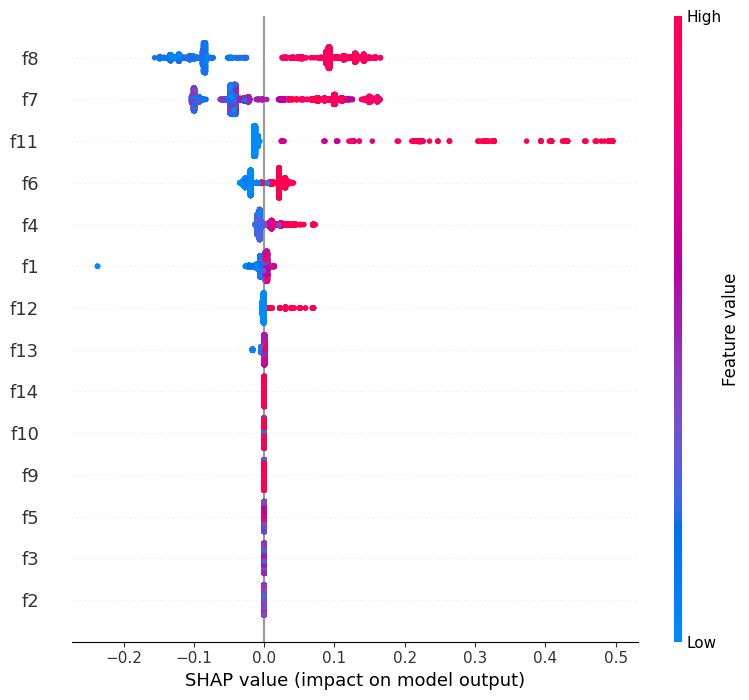

In [46]:
# SHAP (SHapley Additive exPlanations) - это модуль Python, предназначенный для 
# интерпретации и объяснения работы моделей машинного обучения. Он основан на теории Шэпли, 
# которая предлагает способ оценки вклада каждого признака в прогноз модели.

import shap
import numpy as np
import xgboost

X = Xtrain.drop('target', axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Определение параметров модели
params = {
    'objective': 'reg:squarederror',  # или другой подходящий objective
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 10
}

# Подготовка данных и обучение модели
#X, y = shap.datasets.boston()
model = xgboost.train(params, xgboost.DMatrix(X, y), num_boost_round=10)

# Создание объекта Explainer
explainer = shap.TreeExplainer(model)

# Получение SHAP значений для примера данных
shap_values = explainer.shap_values(X)

# Показать вклад каждого признака в прогноз
shap.summary_plot(shap_values, X)

#### Сократим количество признаков и снова обучим пару моделей

In [47]:
X = Xtrain.drop(['target', 'f2', 'f3', 'f5', 'f9', 'f10', 'f14'], axis=1)
y = Xtrain['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [53]:
# Снова посмотрим на рейтинг моделей
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'KNN_GRID': KNeighborsClassifier(metric='euclidean', n_neighbors=2, weights='distance'),
    'LogReg_Grid': LogisticRegression(C=10, solver='liblinear', class_weight='balanced'),
    'KNN_K': KNeighborsClassifier(n_neighbors=optimal_k, weights='distance'),
    'Logreg_C': LogisticRegression(C=best_C),
    'SVC_C': SVC(C=best_C, class_weight='balanced'),
    'SVC_BAL': SVC(class_weight='balanced')
}

# Словарь для хранения результатов F1-меры
f1_scores = {}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1
    print(f'{name} F1 Score: {f1:.2f}')

# Выводим лучшие модели
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
print('\nЛучшие модели по F1 мере:')
for model_name, score in sorted_f1_scores[:2]:
    print(f'{model_name}: {score:.2f}')


KNN F1 Score: 0.65
Logistic Regression F1 Score: 0.72
SVC F1 Score: 0.40
KNN_GRID F1 Score: 0.63
LogReg_Grid F1 Score: 0.69
KNN_K F1 Score: 0.63
Logreg_C F1 Score: 0.73
SVC_C F1 Score: 0.42
SVC_BAL F1 Score: 0.41

Лучшие модели по F1 мере:
Logreg_C: 0.73
Logistic Regression: 0.72


### 5. Оцените на отложенной выборке качество наилучшей модели
В пунктах 3 и 4 вы построили много разных моделей.

Возьмите ту, которая дала наилучшее качество на тестовых данных (Test). Примените её на отложенной выборке (TestData) и выведите на экран значение метрики f1.

In [54]:
X = Xtest.drop('target', axis=1)
y = Xtest['target']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [55]:
# Ваш код здесь

logreg_final = LogisticRegression(C=best_C)
logreg_final.fit(x_train, y_train)

# Предсказания
logreg_pred_c = logreg_final.predict(X)
# Вычисление F-меры
unique_classes = np.unique(y)
res_logreg_c = classification_report(y, logreg_pred_c, target_names=[str(c) for c in unique_classes])

print('best_logreg_c', res_logreg_c)

best_logreg_c               precision    recall  f1-score   support

           0       0.81      0.96      0.88      1913
           1       0.70      0.28      0.40       587

    accuracy                           0.80      2500
   macro avg       0.75      0.62      0.64      2500
weighted avg       0.79      0.80      0.77      2500



In [56]:
svc_c = SVC(C=best_C, class_weight='balanced', probability=True)
svc_c.fit(x_train, y_train)
# Предсказания
svc_c_pred = svc_c.predict(X)
# Вычисление F-меры
unique_classes = np.unique(y)
res_svc_c = classification_report(y, svc_c_pred, target_names=[str(c) for c in unique_classes])

print('svc_c', res_svc_c)

svc_c               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1913
           1       0.52      0.25      0.34       587

    accuracy                           0.77      2500
   macro avg       0.66      0.59      0.60      2500
weighted avg       0.73      0.77      0.74      2500



### 6. Выполните хитрый трюк
Часто смешивание различных моделей даёт улучшение итогового предсказания. Попробуйте смешать две лучшие модели по формуле:
pred_{final} = \alpha\cdot pred_1 + (1-\alpha)\cdot pred_2.

Значение \alpha подберите в цикле по Test-выборке. Оцените качество на отложенной выборке.

Удалось ли добиться улучшения качества?

In [57]:
# Ваш код здесь

# выбираем модели

#pred_knn = knn.predict_proba(X_val)[:, 1]
pred_logreg = logreg_final.predict_proba(X)[:, 1]
pred_svc = svc_c.predict_proba(X)[:, 1]


In [58]:
# Смешиваем предсказания

best_alpha = 0
best_f1 = 0

# Цикл по значениям alpha
alpha_values = np.linspace(0, 1, 50)

for alpha in alpha_values:
    pred_final = alpha * pred_logreg + (1 - alpha) * pred_svc
    pred_final_binary = (pred_final >= 0.5).astype(int)

    f1 = f1_score(y, pred_final_binary)
    
    if f1 > best_f1:
        best_f1 = f1
        best_alpha = alpha

print(f"Лучшее значение alpha: {best_alpha}, F1: {best_f1}")


Лучшее значение alpha: 1.0, F1: 0.40048543689320387


In [59]:
# Оценка результата

# Получаем финальные предсказания для тестовой выборки

pred_logreg_test = logreg_final.predict_proba(X)[:, 1]
pred_svc_test = svc_c.predict_proba(X)[:, 1]

pred_final_test = best_alpha * pred_logreg_test + (1 - best_alpha) * pred_svc_test
pred_final_binary_test = (pred_final_test >= 0.5).astype(int)

# Оценка качества на отложенной выборке
f1_test = f1_score(y, pred_final_binary_test)
print(f"F1 на отложенной выборке: {f1_test}")


F1 на отложенной выборке: 0.40048543689320387


### 7. Сделайте выводы

Запишите в отдельной ячейке текстом выводы о проделанной работе. Для этого ответьте на вопросы:
- Какие подходы вы использовали для улучшения работы baseline-моделей?
- Какого максимального качества удалось добиться на Test-данных?
- Какое при этом получилось качество на отложенной выборке? 
- Ваша модель переобучилась, недообучилась или обучилась как надо?

In [ ]:
# для лучшения использовались:
# GridSearchCV
# Подбор порога
# Подбор гиперпараметра С
# Подбор количества ближайших соседей
# shap для выявления наиболее значимых признаков

Наилучший результат дала модель LogReg с подбором параметров GridSearchCV

             precision    recall  f1-score   support

           0       0.76      0.93      0.84      1275
           1       0.64      0.30      0.41       534

    accuracy                           0.74      1809
   macro avg       0.70      0.62      0.62      1809
weighted avg       0.73      0.74      0.71      1809

подбор парвметров GridSearchCv оказался невероятно затратным и в итоге от него отказался



Результат на отложенной выборке:

best_logreg_c               precision    recall  f1-score   support

           0       0.81      0.96      0.88      1913
           1       0.70      0.28      0.40       587

    accuracy                           0.80      2500
   macro avg       0.75      0.62      0.64      2500
weighted avg       0.79      0.80      0.77      2500

Мое мнение что модель обучилась хорошо

Важный комментарий! В реальных задачах не следует ожидать, что машинным обучением всегда удастся решить задачу с хорошим качеством. Но использовать все имеющиеся у вас в арсенале методы для достижения наилучшего результата нужно.